**CPU usage forecasting with LSTM Recurrent Neural Networks**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Loading CSV file from system to google colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Tools-Cloud-EC2_i-080f2deaf5fdbcae5_Metrics-2021_05_01_08_00_00-2021_06_30_07_00_00-UTC.csv to Tools-Cloud-EC2_i-080f2deaf5fdbcae5_Metrics-2021_05_01_08_00_00-2021_06_30_07_00_00-UTC.csv


The problem solved in this notebook is to forecast CPU usage for coming 30 days, for that we have taken dataset from AWS for Tools-Cloud-EC2 instance.

In [ ]:
df = pd.read_csv("Tools-Cloud-EC2_i-080f2deaf5fdbcae5_Metrics-2021_05_01_08_00_00-2021_06_30_07_00_00-UTC.csv")
df.head()

,Id,metric_alias0,metric_alias1,metric_alias2,metric_alias3,metric_alias4,metric_alias5,metric_alias6,metric_alias7,metric_alias8,metric_alias9,metric_alias10,metric_alias11,metric_alias12,metric_alias13,metric_alias14,metric_alias15,metric_alias16
0,StatusCode,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete,Complete
1,Messages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Full label,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...,ap-south-1:AWS/EC2 InstanceId:i-080f2deaf5fdbc...
3,Label,CPUCreditBalance,CPUCreditUsage,CPUSurplusCreditBalance,CPUSurplusCreditsCharged,CPUUtilization,DiskReadBytes,DiskReadOps,DiskWriteBytes,DiskWriteOps,MetadataNoToken,NetworkIn,NetworkOut,NetworkPacketsIn,NetworkPacketsOut,StatusCheckFailed,StatusCheckFailed_Instance,StatusCheckFailed_System
4,2021/05/01 08:00:00,1296,0.03813875,NaN,NaN,0.18957677286892777,NaN,NaN,NaN,NaN,NaN,29545.266666666666,23359.716666666667,140.06666666666666,127.5,NaN,NaN,NaN


Below cell takes the dataset and discard all variables/features except timestamp and CPUUtilization

In [ ]:
to_drop = ['metric_alias0','metric_alias1','metric_alias2','metric_alias3','metric_alias5','metric_alias6','metric_alias7','metric_alias8','metric_alias9','metric_alias10','metric_alias11','metric_alias12','metric_alias13','metric_alias14','metric_alias15','metric_alias16']
df.drop(to_drop, inplace=True, axis=1)

Below cell discard first 4 rows from our dataset as they are dump values

In [ ]:
df = df.drop(df.index[[0, 1, 2, 3]])

Below cell changes the column names of dataset, convert 'time' to pandas datetime and convert the 'cpu' column values to floating point values, which are more suitable for modeling with a neural network.

In [ ]:
df.columns = ['time','cpu']
df['time'] = pd.to_datetime(df['time'])
df['cpu'] = df['cpu'].astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 4 to 1443
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1440 non-null   datetime64[ns]
 1   cpu     1440 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.8 KB


Below cell is written to remove outliers, as our dataset contain lot of outliers and replacing them with median value.

In [ ]:
i = 4
while i < len(df):
  if df.at[i,'cpu'] > 3:
    df.at[i,'cpu'] = df['cpu'].median()
  i += 1

The code below is to load and plot the dataset, we can see that almost 97% values are in range between 0.2 to 0.3.

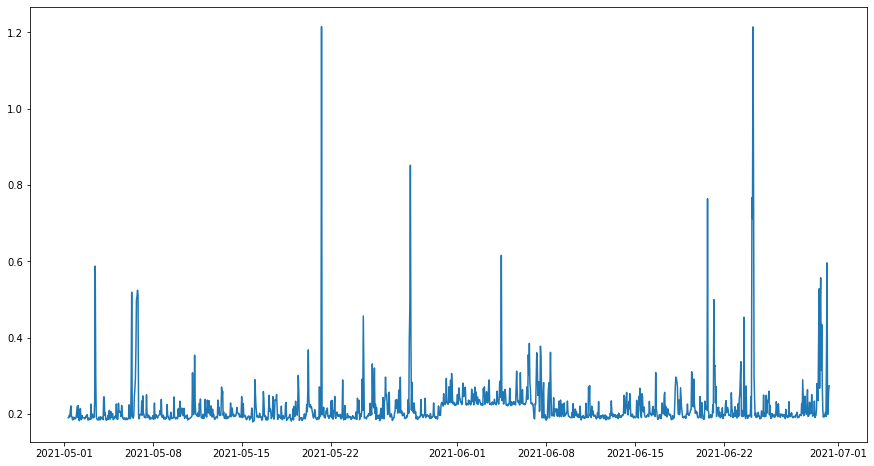

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(df['time'], df['cpu'])
plt.show()

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid or tanh activation functions are used. we need to rescale the data to the range of 0 to 1, normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = df['cpu'].values.reshape(-1, 1)
dataset = scaler.fit_transform(dataset)

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [ ]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

964 476


Below cell is a function to create a new dataset. The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period which is 1 in our case, i.e we want to predict next 1 step. This creates a dataset where dataX is the cpu usage at a given time (t) and dataY is the cpu usage at the next time (t + 1).

From this we will construct a differently shaped dataset.

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Below cell prepares the train and test datasets for modeling, look back 12 means to compute next value we will take previous 12 values i.e taking previous 12 hours value

In [ ]:
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

This is how we have changed the shape of out dataset 951 x 12 represent 951 rows and 12 represent 1 rows contain previous 12 hours data

In [ ]:
print(trainX.shape)
print(trainX[:3])

(951, 12)
[[0.01064577 0.01135252 0.01668201 0.01339344 0.02942902 0.04082732
  0.01463829 0.01336925 0.00594726 0.00531405 0.01199523 0.01196433]
 [0.01135252 0.01668201 0.01339344 0.02942902 0.04082732 0.01463829
  0.01336925 0.00594726 0.00531405 0.01199523 0.01196433 0.00795413]
 [0.01668201 0.01339344 0.02942902 0.04082732 0.01463829 0.01336925
  0.00594726 0.00531405 0.01199523 0.01196433 0.00795413 0.00932387]]


The LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows.

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
print(trainX.shape)
print(trainX[:3])

(951, 1, 12)
[[[0.01064577 0.01135252 0.01668201 0.01339344 0.02942902 0.04082732
   0.01463829 0.01336925 0.00594726 0.00531405 0.01199523 0.01196433]]

 [[0.01135252 0.01668201 0.01339344 0.02942902 0.04082732 0.01463829
   0.01336925 0.00594726 0.00531405 0.01199523 0.01196433 0.00795413]]

 [[0.01668201 0.01339344 0.02942902 0.04082732 0.01463829 0.01336925
   0.00594726 0.00531405 0.01199523 0.01196433 0.00795413 0.00932387]]]


The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
951/951 - 18s - loss: 0.0033
Epoch 2/100
951/951 - 1s - loss: 0.0030
Epoch 3/100
951/951 - 1s - loss: 0.0029
Epoch 4/100
951/951 - 1s - loss: 0.0028
Epoch 5/100
951/951 - 1s - loss: 0.0028
Epoch 6/100
951/951 - 1s - loss: 0.0027
Epoch 7/100
951/951 - 1s - loss: 0.0028
Epoch 8/100
951/951 - 1s - loss: 0.0027
Epoch 9/100
951/951 - 1s - loss: 0.0027
Epoch 10/100
951/951 - 1s - loss: 0.0027
Epoch 11/100
951/951 - 1s - loss: 0.0027
Epoch 12/100
951/951 - 1s - loss: 0.0027
Epoch 13/100
951/951 - 1s - loss: 0.0026
Epoch 14/100
951/951 - 1s - loss: 0.0027
Epoch 15/100
951/951 - 1s - loss: 0.0026
Epoch 16/100
951/951 - 1s - loss: 0.0026
Epoch 17/100
951/951 - 1s - loss: 0.0026
Epoch 18/100
951/951 - 1s - loss: 0.0026
Epoch 19/100
951/951 - 1s - loss: 0.0026
Epoch 20/100
951/951 - 1s - loss: 0.0026
Epoch 21/100
951/951 - 1s - loss: 0.0026
Epoch 22/100
951/951 - 1s - loss: 0.0026
Epoch 23/100
951/951 - 1s - loss: 0.0026
Epoch 24/100
951/951 - 1s - loss: 0.0026
Epoch 25/100
951/951 - 1

Our model is ready, we can estimate the performance of the model on the train and test datasets.

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.07 RMSE


Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the training dataset in blue, the predictions for the test dataset in green.

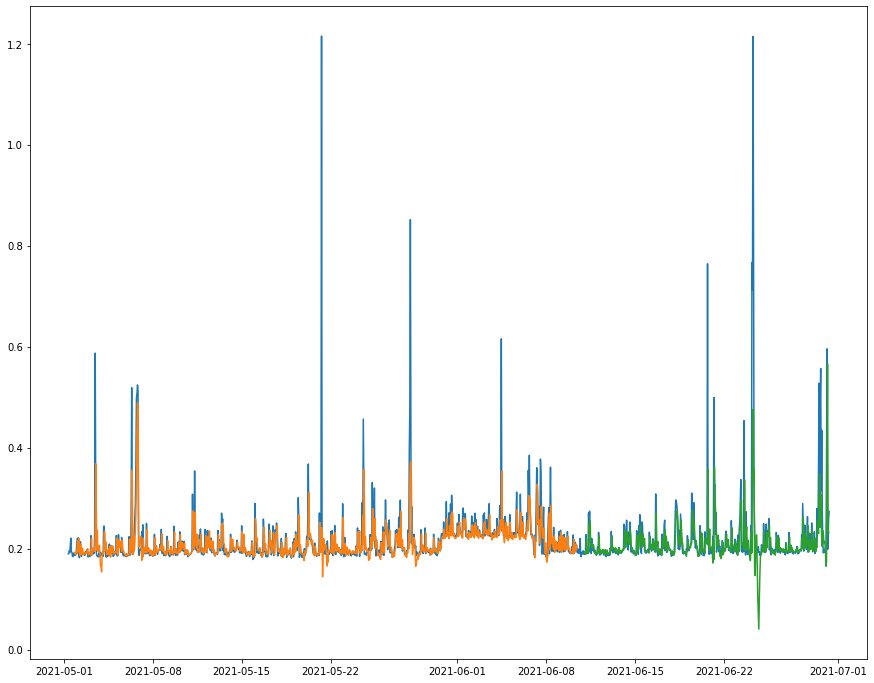

In [ ]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15,12))
plt.plot(df['time'],scaler.inverse_transform(dataset))
plt.plot(df['time'],trainPredictPlot)
plt.plot(df['time'],testPredictPlot)
plt.show()

Below cell display last 2 rows of our test dataset.

In [ ]:
print(testX[461:])

[[[0.24686136 0.09103678 0.03262173 0.01264222 0.01727651 0.01325906
   0.01874695 0.02468472 0.0139846  0.17759933 0.40258171 0.01929976]]

 [[0.09103678 0.03262173 0.01264222 0.01727651 0.01325906 0.01874695
   0.02468472 0.0139846  0.17759933 0.40258171 0.01929976 0.02072664]]]


Notice below cell takes input only last row of our test dataset and store cpu usage prediction for coming 30 days in lst_output.

In [ ]:
# demonstrate prediction for next 30 days
from array import array
x_input = [0.09103678, 0.03262173, 0.01264222, 0.01727651, 0.01325906, 0.01874695, 0.02468472, 0.0139846,  0.17759933, 0.40258171, 0.01929976, 0.02072664]
x_input = np.array(x_input)
temp_input=list(x_input)
lst_output=[]
i=0
while(i<31):
    
    if(len(temp_input)>12):
        x_input=temp_input[1:]
        print("{} day input {}".format(i,x_input))
        x_input = np.array(x_input)
        x_input = x_input.reshape((1, 1, look_back))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, 1, look_back))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

[0.05126844]
1 day input [0.03262173, 0.01264222, 0.01727651, 0.01325906, 0.01874695, 0.02468472, 0.0139846, 0.17759933, 0.40258171, 0.01929976, 0.02072664, 0.051268436]
1 day output [[0.04628098]]
2 day input [0.01264222, 0.01727651, 0.01325906, 0.01874695, 0.02468472, 0.0139846, 0.17759933, 0.40258171, 0.01929976, 0.02072664, 0.051268436, 0.046280976]
2 day output [[0.02804195]]
3 day input [0.01727651, 0.01325906, 0.01874695, 0.02468472, 0.0139846, 0.17759933, 0.40258171, 0.01929976, 0.02072664, 0.051268436, 0.046280976, 0.028041946]
3 day output [[0.02452232]]
4 day input [0.01325906, 0.01874695, 0.02468472, 0.0139846, 0.17759933, 0.40258171, 0.01929976, 0.02072664, 0.051268436, 0.046280976, 0.028041946, 0.02452232]
4 day output [[0.03367103]]
5 day input [0.01874695, 0.02468472, 0.0139846, 0.17759933, 0.40258171, 0.01929976, 0.02072664, 0.051268436, 0.046280976, 0.028041946, 0.02452232, 0.03367103]
5 day output [[0.04493647]]
6 day input [0.02468472, 0.0139846, 0.17759933, 0.40258

Forecasting cpu usage for coming 30 days.

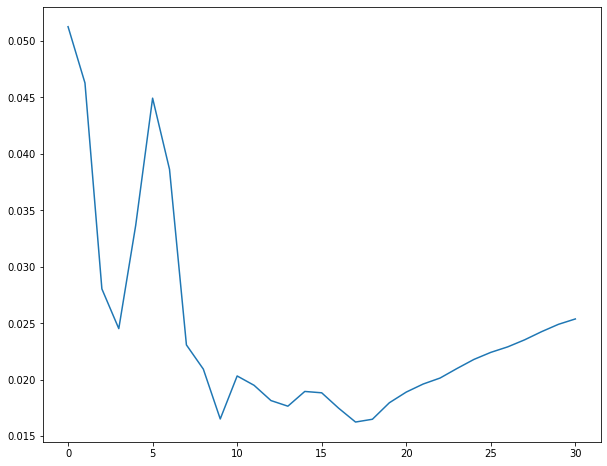

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(lst_output)
plt.show()